In [189]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import time # modeli yaddaşa verərkən lazımdır

In [190]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
#   plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
#   plt.ylim([0,20])

In [191]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

In [192]:
car_data = '07_LADA.csv'

In [193]:
column_names = ['car_name', 'price', 'year', 'engine', 'mileage', 'valyuta']

raw_dataset = pd.read_csv(car_data, names=column_names, na_values = "?", comment='\t', sep=",", skipinitialspace=True,
                          encoding='ISO-8859-1')

dataset = raw_dataset.copy()

In [194]:
dataset.head()

,car_name,price,year,engine,mileage,valyuta
0,LADA (VAZ) 2107,6900,2012,1.6,10900,AZN
1,LADA (VAZ) 2107,6100,2010,1.6,151365,AZN
2,LADA (VAZ) 2107,6600,2010,1.6,150000,AZN
3,LADA (VAZ) 2107,3100,2000,1.6,165000,AZN
4,LADA (VAZ) 2107,3900,2003,1.6,250000,AZN


In [195]:
# Maşın adı və valyuta sütunlarını siyahıdan çıxarırıq. 
# Çünki, onlar bütü sətirlərdə eynidir. İstəsəniz motor ölçüsünü də çıxara bilərsiniz.
dataset.pop('car_name')
dataset.pop('valyuta')
# Sütunları çıxdıqdan sonra məlumata baxaq və əmin olaq ki, sütunlar yoxdur.
dataset.head()

,price,year,engine,mileage
0,6900,2012,1.6,10900
1,6100,2010,1.6,151365
2,6600,2010,1.6,150000
3,3100,2000,1.6,165000
4,3900,2003,1.6,250000


In [196]:
# Beləliklə əmin oluruq ki, məlumatların hamısı tamdır. Yəni, hər hansı bir sətirdə və ya sütunda məlumat çatışmazlığı yoxdur.
dataset.isna().sum()

price      0
year       0
engine     0
mileage    0
dtype: int64

In [197]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

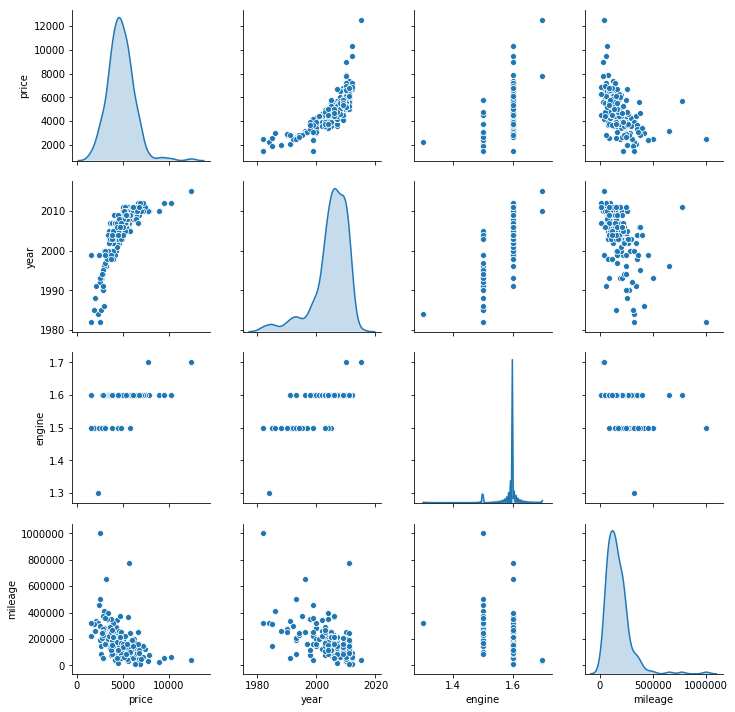

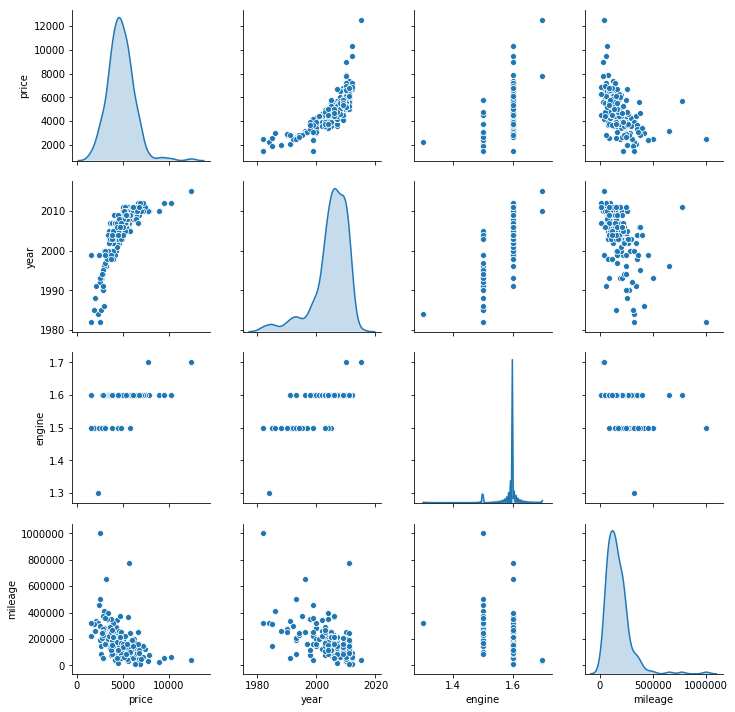

In [198]:
sns_plot = sns.pairplot(train_dataset[["price", "year", "engine", "mileage"]], diag_kind="kde")
sns.pairplot(train_dataset[["price", "year", "engine", "mileage"]], diag_kind="kde")

sns_plot.savefig('output_07_LADA.png')

In [199]:
train_dataset.describe()

,price,year,engine,mileage
count,239.000000,239.000000,239.000000,239.000000
mean,4814.602510,2005.075314,1.589540,168119.271967
std,1428.466795,5.883549,0.036888,113317.361776
min,1500.000000,1982.000000,1.300000,10900.000000
25%,3900.000000,2003.000000,1.600000,94164.500000
50%,4700.000000,2006.000000,1.600000,150000.000000
75%,5600.000000,2009.000000,1.600000,213455.000000
max,12500.000000,2015.000000,1.700000,1000000.000000


In [200]:
test_dataset.describe()

,price,year,engine,mileage
count,60.000000,60.000000,60.000000,6.000000e+01
mean,4658.333333,2003.966667,1.578333,2.366947e+05
std,1430.898931,6.794730,0.061318,3.778951e+05
min,2200.000000,1983.000000,1.300000,3.212200e+04
25%,3600.000000,2000.750000,1.600000,9.584175e+04
50%,4700.000000,2006.000000,1.600000,1.600000e+05
75%,5625.000000,2009.000000,1.600000,2.181110e+05
max,8300.000000,2012.000000,1.600000,2.884486e+06


In [201]:
train_stats = train_dataset.describe()
train_stats.pop("price")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
year,239.0,2005.075314,5.883549,1982.0,2003.0,2006.0,2009.0,2015.0
engine,239.0,1.589540,0.036888,1.3,1.6,1.6,1.6,1.7
mileage,239.0,168119.271967,113317.361776,10900.0,94164.5,150000.0,213455.0,1000000.0


In [202]:
# Biz burada qiyməti tapacağımıza görə həm train, həm də test dataset-dən price sütununu silməliyik.
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

In [203]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
# Aşağıdakı ikisini comment etsəniz, bu zaman real normallaşdırılmış məlumat işə düşəcəkdir.
normed_train_data = train_dataset
normed_test_data = test_dataset

In [243]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(32, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]))
    model.add(layers.Dense(32, activation=tf.nn.relu))
    model.add(layers.Dense(1)) 
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [244]:
model = build_model()

In [245]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [246]:
normed_train_data.fillna(0, inplace=True)
normed_train_data[:10]

,year,engine,mileage
206,2008,1.6,84000
188,1996,1.6,654989
12,2006,1.6,370000
219,2010,1.6,80000
237,2010,1.6,65000
136,2009,1.6,67000
228,2007,1.6,178000
205,2008,1.6,142930
52,2007,1.6,57567
108,2000,1.6,289146


In [247]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print(example_result)

[[ -27965.398]
 [-219791.38 ]
 [-124044.42 ]
 [ -26622.127]
 [ -21585.748]
 [ -22257.383]
 [ -59539.46 ]
 [ -47757.125]
 [ -19090.41 ]
 [ -96881.28 ]]


In [248]:
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


...........................

In [249]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
22,1.615246e+07,3555.458496,1.615246e+07,1.426304e+07,3063.009689,1.426304e+07,22
23,1.162876e+07,2806.053385,1.162876e+07,1.528989e+07,3179.482814,1.528989e+07,23
24,1.245045e+07,2944.696777,1.245045e+07,1.302797e+07,2901.645850,1.302797e+07,24
25,1.460409e+07,3299.750651,1.460409e+07,1.268776e+07,2843.890449,1.268776e+07,25
26,1.147842e+07,2783.242757,1.147842e+07,1.134536e+07,2767.158365,1.134536e+07,26


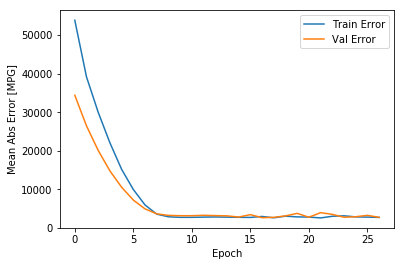

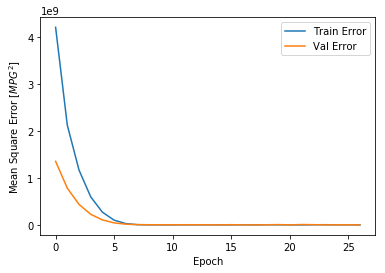

In [250]:
plot_history(history)

Testing set Mean Abs Error: 3682.58 AZN


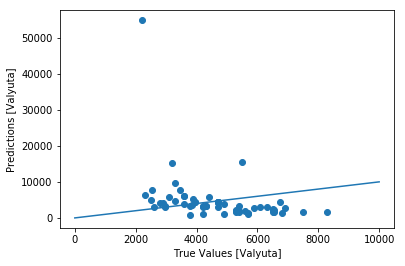

In [251]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} AZN".format(mae))

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Valyuta]')
plt.ylabel('Predictions [Valyuta]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _ = plt.plot([-100, 100], [-100, 100])
plt.plot([0, 10000], [0, 10000])

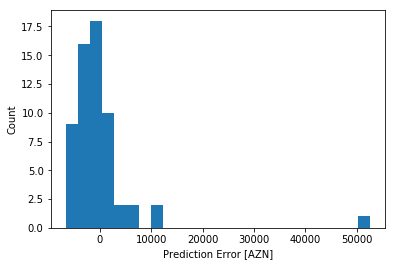

In [252]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [AZN]")
_ = plt.ylabel("Count")

In [253]:
test_predictions = model.predict(normed_test_data).flatten()

In [254]:
test_predictions

array([ 3151.448 ,  5847.5225,  1187.5736,  6337.5527,  2119.6711,
        3314.43  ,  3403.3352,  3163.0217,  2123.3743,  1569.0828,
        3123.9148,  1138.8663,  7662.252 ,  1896.3342, 54826.773 ,
        3256.7004,  5014.4263,  2142.2808,  7784.5117,  2577.5947,
        5109.253 ,  2747.623 ,  2047.8845,  3141.097 ,  4048.8801,
        3295.3782,  4257.6826,  2664.309 ,  2936.5588,  5676.0586,
        1745.6467,  1234.8506,  4349.2695,  3824.6614,  5960.3926,
        3408.3943, 15604.762 ,   893.9973,  3597.6223,  3940.0188,
       15343.93  ,  1348.4349,  9666.214 ,  1669.7273,  4712.1816,
        1612.7158,  1754.5032,  5954.866 ,  1914.1277,  1158.9243,
        1688.3462,  4324.8706,  3125.2073,  4412.7583,  4324.8706,
        3313.7112,  4412.7583,  4324.8706,  4324.8706,  4324.8706],
      dtype=float32)

In [255]:
new_data = pd.DataFrame({ 'year': [2010], 'engine': [1.6], 'mileage': [160000] })
normalized_new_data = new_data

In [256]:
model.predict(new_data).flatten()

array([3314.7197], dtype=float32)